<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Using Landlab's gradient and flux divergence functions

<hr>
<small> (Note: for instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/gradient_and_divergence/gradient_and_divergence_unexpanded.ipynb">https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/gradient_and_divergence/gradient_and_divergence_unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>)
<hr>

Models of geophysical flow phenomena very commonly include gradient terms and flux divergence terms in their governing equations. Consider the example of conductive heat diffusion in two dimensions. The *flux* of heat, $q$, at a point (in energy per time per area) depends on the *gradient* in temperature:

$q_x = -k \frac{\partial T}{\partial x}$

$q_y = -k \frac{\partial T}{\partial y}$

where the subscripts denote the two directions. The time rate of change of thermal energy depends on the derivative of flux, or *flux divergence*:

$\frac{dT}{dt} \propto -\left( \frac{\partial q_x}{\partial x} + \frac{\partial q_y}{\partial y} \right)$

In a finite-difference or finite-volume solution, the quantities $T$ and $q$ are solved at discrete points. Staggered-grid schemes will place the scalar quantity ($T$) at one set of grid locations, and the vector quantity ($q$) at "in-between" locations.

In Landlab, such a staggered grid is easy to implement by locating scalar quantities at nodes, and locating vector quantities at either links. Landlab also provides a set of "one-liner" functions to calculate the gradients in a quantity located at nodes or cells, as well as to calculate the net flux or flux divergence in a vector quantity located at faces or links. This tutorial shows you examples of how to use these.

We'll start with a tiny grid, so it's easy to see what the various flavors of the gradient and flux functions do. Then we'll try them out on the example of a landform undergoing soil creep, which is the same example used in an introductory Landlab tutorial.

## Tiny grid example

We'll start with a 3-row by 4-column raster grid, with 10-meter node spacing.

In [1]:
import numpy
from landlab import RasterModelGrid
mg = RasterModelGrid((3, 4), 10.0)

Create a scalar field called `z`, representing elevation of the land surface, at the grid nodes:

In [2]:
z = mg.add_zeros('node', 'topographic__elevation')
z[5] = 5.0
z[6] = 3.6

Nodes 5 and 6 are the only core nodes; the rest are (so far) open boundaries. 

Here are the values. 

In [3]:
z

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  5. ,  3.6,  0. ,  0. ,  0. ,  0. ,
        0. ])

Nodes in a raster grid are numbered by row, starting from the bottom. In the array above, the first four are the bottom row, the next four are the middle row, and the last four are the top row. (Note that in general, nodes in any Landlab grid will be numbered in increasing order by their $y$ coordinates; nodes with equal $y$ coordinates, as in the case of rows in a raster grid, will then be numbered in order by $x$)

Let's take a graphical look at the elevation grid we've created. To do so, we'll use the Pylab graphics library (imported under the name `plt`). We also have to tell the iPython Notebook to display plots right here on the page. Finally, we will import Landlab's `imshow_grid` function to display our gridded values.

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
from landlab.plot.imshow import imshow_grid

Let's plot the elevation values:

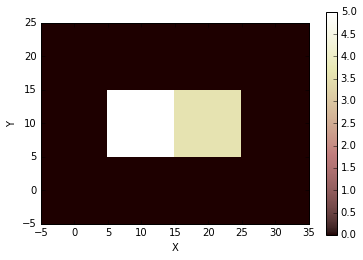

In [6]:
imshow_grid(mg, 'topographic__elevation')

There are elevation values associated with all 12 of the nodes on the grid. The ones shown in black are **boundary nodes**; the two in the middle are **core nodes**. This is our *scalar field*.

## Links and gradients

Next, we will calculate the gradient in this field of elevation values. We want to find the gradient between each pair of adjacent nodes, and store that value at the associated **link** between them.

### What are links?

For each pair of adjacent nodes in a Landlab grid, there is a corresponding **link**. Links are directed line segments whose endpoints are the coordinates of the nodes. A link can be illustrated like this:

    o---->o

Here, each o represents a node, and the arrow is the link. A "vertical" link looks like this:

    o
    ^
    |
    |
    o

The tip of the arrow is known as the **link head**; the base of the arrow is known as the **link tail**. By default, links always "point" within the upper-right quadrange.

With this definition of links in mind, we can sketch our grid like so, with the ID numbers of the nodes shown by the numbers:


    8 ----> 9 ----> 10----> 11
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    4 ----> 5 ----> 6 ----> 7
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ----> 1 ----> 2 ----> 3


If we label each node with its elevation value, it looks like this:


    0 ----> 0 ----> 0 ----> 0
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ---->5.0---->3.6----> 0
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ----> 0 ----> 0 ----> 0


### Calculating the gradient of a node field at links

To calculate the gradient of a node field, with one gradient value for each link, use the function `calc_grad_at_link`:

In [7]:
dzdx = mg.calc_grad_at_link(z)
dzdx

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.36,  0.  ,  0.5 , -0.14,
       -0.36,  0.  , -0.5 , -0.36,  0.  ,  0.  ,  0.  ,  0.  ])

Here's a crude graphical representation of gradient array:


    o ---0--> o ---0--> o ---0--> o
    ^         ^         ^         ^
    0       -0.5      -0.36       0
    |         |         |         |
    o  +0.5 > o -0.14 > o -0.36 > o
    ^         ^         ^         ^
    0       +0.5      +0.36       0
    |         |         |         |
    o ---0--> o ---0--> 0 ---0--> 0

Links are listed in order by the $(x, y)$ coordinates of their midpoints. The ID numbering scheme for our links looks like this:


    o --14--> o --15--> o --16--> o
    ^         ^         ^         ^
    10       11        12        13
    |         |         |         |
    o ---7--> o ---8--> o ---9--> o
    ^         ^         ^         ^
    3         4         5         6
    |         |         |         |
    o ---0--> o ---1--> 0 ---2--> 0

Let's explore how the geometry and the values in the ID array of gradients correspond. Here are the gradients first three are the horizontal links along the bottom edge of the grid:

In [8]:
dzdx[0:3]

array([ 0.,  0.,  0.])

Next come four vertical links that connect the bottom to the middle rows of nodes. Two of these values are positive, indicating an *uphill gradient in the direction of the links*:

In [9]:
dzdx[3:7]

array([ 0.  ,  0.5 ,  0.36,  0.  ])

Now the middle row of horizontal links:

In [10]:
dzdx[7:10]

array([ 0.5 , -0.14, -0.36])

The next row of vertical links. The middle two of these are negative, indicating a downhill slope in the direction of the links:

In [11]:
dzdx[10:14]

array([ 0.  , -0.5 , -0.36,  0.  ])

Finally, the top row of horizontal links:

In [12]:
dzdx[14:17]

array([ 0.,  0.,  0.])

So far, we've seen how to perform a centered-difference gradient calculation using Landlab's `calc_grad_at_link` function. Next, let's look at the flux divergence operation: adding up all the incoming and outgoing fluxes at a location.

## Cells and flux divergence

### A quick look at finite-volume numerical methods

The *finite-volume method* is a type of numerical approach that is similar to the more familiar finite-difference method. For many problems that are discretized on a regular grid, the two methods turn out to be equivalent. For our next step, we'll take a finite-volume approach, which turns out to be fairly intuitive.

Consider a rectangular *cell* of dimensions $\Delta x$ by $\Delta y$:

    o-------o
    |       |
    |       |
    |       |
    o-------o

Imagine that the cell represents a patch of ground on a hill. Along each edge of the rectangle, soil is gradually flowing either into or out of the cell. If more soil flows in than flows out, the cell's elevation will rise (we are assuming the soil bulk density is constant). If more soil flows out than flows in, the cell's elevation will shrink.

Suppose we know the average soil flux along each side of the cell. If we use the compass directions *N, S, E, W* to denote the four sides, we might represent these average fluxes as follows: $q_N, q_S, q_E, q_W$.

Let's take the convention that flow is always *positive* when it is going north or east, and negative when it is going south or west. With that in mind, we could compute the *net outflux of soil* as follows:

$Q_{net} = -q_E \Delta y - q_N \Delta x + q_W \Delta y + q_S \Delta x$

The *rate* at which the cell's average elevation is rising or falling could be expressed as:

$\frac{dz}{dt} = -\frac{Q_{net}}{\Delta x \Delta y}$

The term on the right side is a finite-volume approximation of the flux divergence. In commonly used symbols,

$\nabla \mathbf{q} = \left( \frac{\partial q_x}{\partial x} + \frac{\partial q_y}{\partial y} \right) \approx \frac{Q_{net}}{\Delta x \Delta y}$

This is the quantity we would like to calculate for the nodes in our grid.

### More on grid geometry: nodes and cells

In a Landlab grid, a *cell* is a polygon that contains a single *node*, which is a point. Every cell has one and only one node. However, not every node has a cell: the grid's perimeter consists of nodes without cells.

In our tiny grid example, there are 12 nodes. Ten of these lie on the grid's perimeter. Therefore, our grid has only two cells: one containing node 5, and one containing node 6. The geometry is crudely sketched here:


    b       b       b       b

        .-------.-------.
        |       |       |
    b   |   c   |   c   |   b
        |       |       |
        .-------.-------.

    b       b       b       b


Here, the letter `b` represents boundary nodes (10 of them), the letter `c` represents core nodes (2 of them), and the lines are the *faces* of the two cells. (The periods are called *corners*; we won't deal with them further in this tutorial.)

Our aim is to calculate a *soil flux* across each cell face, and then add up all in the incoming and outgoing fluxes.

Before we do this, notice that each face is crossed by a link. For example, there is a link running from the left core node to the right core node. Our strategy, therefore, will be to calculate a flux value for each link in the grid. The model we'll use will be the soil-transport law (sometimes known as Gilbert's Law):

$\mathbf{q} = -D \nabla z$

Here, $\nabla z$ is simply the gradient. We have already discretized the gradient, placing the gradient between each pair of adjacent nodes at the corresponding link. *This means we have already defined values of the gradient across each cell face* (as well as several links along the grid perimeter that don't cross cell faces).

We can calculate fluxes along grid links with a single expression: 

In [13]:
D = 0.01
q = -D * dzdx
q

array([-0.    , -0.    , -0.    , -0.    , -0.005 , -0.0036, -0.    ,
       -0.005 ,  0.0014,  0.0036, -0.    ,  0.005 ,  0.0036, -0.    ,
       -0.    , -0.    , -0.    ])

Now, in order to calculate the flux divergence at our two cells, we need to do the following steps:

1 - For each cell, multiply the four flux values by the width of the cell (which is the same for every face in this grid).

2 - Add up the incoming fluxes and subtract the outgoing fluxes.

3 - Divide by the area of the cell.

The result will be a numerical approximation of the flux-divergene term.

It turns out that you can do with with a single Landlab function call:

In [14]:
dqda = mg.calc_flux_div_at_node(q)

At this point, you might be wondering why the function name says `_at_node` rather than `at_cell`. This is because Landlab assigns a value to each node. For the perimeter nodes, the value will be zero, because they have no cells and the calculation is meaningless. However, the two *core nodes*, which do have cells, **will** have meaningful values. Let's look at these values:

In [15]:
dqda

array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.00164,
        0.00094,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ])

Flux-divergence values for the two core nodes are 0.00164 and 0.00094, respectively. Let's look at how these values came to be. For node 5, the fluxes per unit width ("unit fluxes") along the faces of its cell are as follows:

$q_E = -0.005$ m$^2$/yr

$q_N = -0.005$ m$^2$/yr

$q_W = -0.0014$ m$^2$/yr

$q_S = -0.005$ m$^2$/yr

So, this cell is leaking soil in every direction. The *total* fluxes along each cell, which we'll represent with the symbol $Q$, are obtained by multiplying each unit flux by the width of the face, which in this case is 10 meters:

$Q_E = -0.05$ m$^3$/yr

$Q_N = -0.05$ m$^3$/yr

$Q_W = -0.014$ m$^3$/yr

$Q_S = -0.05$ m$^3$/yr

The total volume loss rate from the cell is 0.164 m$^3$/yr. Dividing this by the cell's surface area of 100 m$^2$, the cell's rate of change in average elevation is 0.00164 m/yr.

For node 6, the unit fluxes are:

$q_E = -0.0036$ m$^2$/yr

$q_N = -0.0036$ m$^2$/yr

$q_W = +0.0014$ m$^2$/yr

$q_S = -0.0036$ m$^2$/yr

So the cell at node 6 is leaking soil in three directions, but gaining a little bit from the higher cell to its west.
Its total fluxes are:

$Q_E = -0.036$ m$^3$/yr

$Q_N = -0.036$ m$^3$/yr

$Q_W = +0.014$ m$^3$/yr

$Q_S = -0.036$ m$^3$/yr

This gives a net flux of 0.094 m$^3$/yr, and a rate of elevation change of 0.00094 m/yr.

If you want the net flux rather than flux divergence, you can get this with the `calc_net_flux_at_node` function:

In [16]:
mg.calc_net_flux_at_node(q)

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.164,  0.094,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ])

Notice that it correctly returns the values we computed above.

## Not just for raster grids

The grid functions `calc_grad_at_link` and `calc_flux_div_at_node` functions also work on hexagonal and irregular grids. Under the hood, Landlab takes account of the differences in face width, link length, cell area, and so on.

## Optimizing performance

With the usage illustrated above, Landlab will create and populate a new return array each time you call one of these functions. This costs computing time. To speed things up, you can pre-allocate your arrays and pass them in as arguments using the `out` keywork. For example, an alternative way to do our gradient calculation is as follows:

In [17]:
# Do this step ONCE, on initialization
dzdx = mg.add_zeros('link', 'topographic__gradient_of_elevation')

# Do this step many times, in a loop
mg.calc_grad_at_link(z, out=dzdx)
dzdx

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.36,  0.  ,  0.5 , -0.14,
       -0.36,  0.  , -0.5 , -0.36,  0.  ,  0.  ,  0.  ,  0.  ])

In this case the Landlab will places the results of the calculation in the array you passed, rather than allocating memory for a new array. The same applies to `calc_flux_div_at_node` and `calc_net_flux_at_node`.

In the example above, we created `dzdx` as a grid field, but you can alternatively pass in an empty or zero-valued NumPy array:

In [18]:
from numpy import zeros

# Do this step ONCE, on initialization
dzdx = zeros(mg.number_of_links)

# Do this step many times, in a loop
mg.calc_grad_at_link(z, out=dzdx)
dzdx

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.36,  0.  ,  0.5 , -0.14,
       -0.36,  0.  , -0.5 , -0.36,  0.  ,  0.  ,  0.  ,  0.  ])

## Where to learn more

- The **fault scarp tutorial** provides an example of `calc_grad_at_link` and `calc_flux_div_at_node`

- See entries for these two functions in Landlab's *Reference Manual and API Documentation*

- The complete code for this tutorial is also available as a stand-alone Python program: https://github.com/landlab/tutorials/blob/master/gradient_and_divergence/gradient_and_divergence.py

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>